In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import Tree
np.random.seed(1)

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


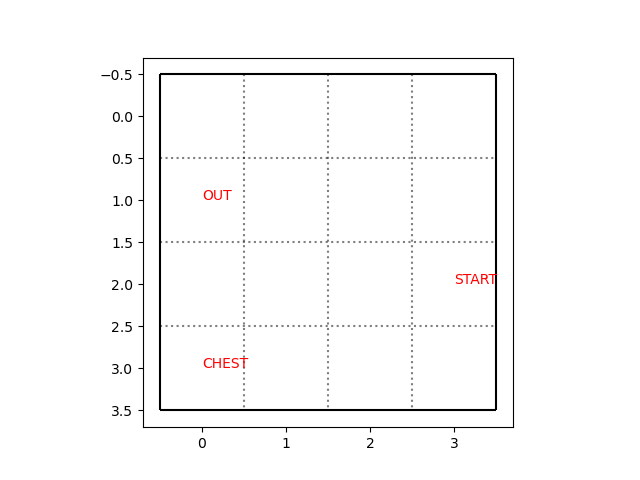

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [2]:
N_grid = 4

tree = Tree.Cell_Tree( N_grid )

tree.visu()


In [4]:
N_state = 3 ### START, OUT_OPEN, OUT_CLOSE
N_action = tree.N_Wall

### Initialize the Q-table to 0
Q_table = np.zeros(( N_state, N_action ))


In [5]:
### number of episode we will run
N_episodes = 500
### Max number of action per episode
N_max_action = N_action*2

### Initialize the exploration probability to 1
exploration_proba = 1
### Exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.005
### Minimum of exploration proba
min_exploration_proba = 0.01

### Discounted factor : gamma or discount
discount = 0.9
### learning rate or alpha
lr = 0.1

total_rewards_episode = np.zeros( N_episodes )

<IPython.core.display.Javascript object>


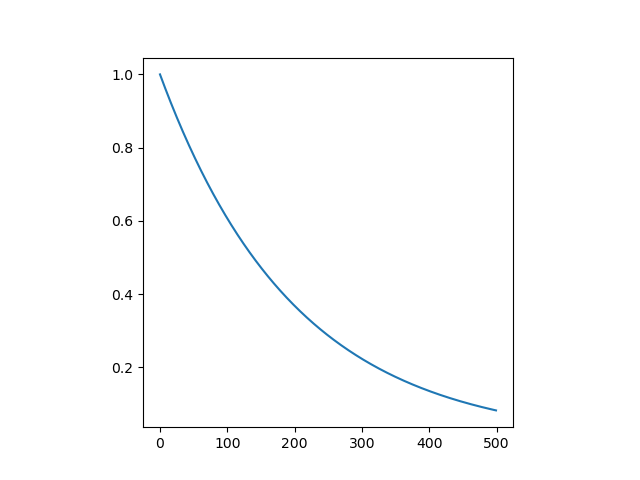

In [6]:
fig, ax = plt.subplots()

ax.plot( np.arange( N_episodes ), np.exp(-exploration_decreasing_decay*np.arange( N_episodes )) )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [7]:

    
def do_action( Wall_ID, tree ):
    ### The action will change the state of the wall
    ### build or brake the wall
    
    if tree.Wall_state[Wall_ID] :
        tree.brake_WALL( Wall_ID )
    else :
        tree.build_WALL( Wall_ID )
                
def sample_action( N_action ):
    return np.random.randint(N_action)

def step(tree, action):
    do_action( action, tree )
    new_state = get_state( tree )
    reward = get_reward( tree )
    
    done = False
    #if new_state == 2:
    #    done =True
    
    return new_state, reward, done
    
def get_state( tree ):
    if tree.check():
        return 1 ### OUT ACCESSIBLE
    else:
        return 2 ### OUT NOT ACCESSIBLE
    
def get_reward( tree ):
    state = get_state( tree )
    if state == 1:
        return 1
    if state == 2:
        return -1
    


In [ ]:
### we iterate over episodes
for e in range(N_episodes): 
    
    if not(e%100):
        print( e,'/',N_episodes )

    ### we initialize the first state of the episode
    current_state = 0 ### START state OUT ACCESSIBLE
    tree.reset_tree()
    done = False
    
    #sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(N_max_action): 
        ### we sample a float from a uniform distribution over 0 and 1
        # if the sampled float is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            
            action = sample_action( N_action )
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done = step(tree, action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr)*Q_table[current_state, action] +lr*(reward + discount*max(Q_table[next_state,:]))
                
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            print( 'HERE WE BREAK' )
            break
        current_state = next_state
    #We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    total_rewards_episode[e] = total_episode_reward

0 / 500
100 / 500
200 / 500
300 / 500


In [ ]:
Q_table

In [ ]:
fig, ax = plt.subplots()

ax.plot( np.arange( N_episodes ), total_rewards_episode )

kernel = 20
moy_roulante = np.convolve( total_rewards_episode , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1,N_episodes  ), moy_roulante )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [ ]:
tree.visu()

In [ ]:
### we iterate over episodes
for e in range(N_episodes): 

    ### we initialize the first state of the episode
    current_state = 0 ### START state OUT ACCESSIBLE
    done = False
    
    #sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(N_max_action): 
        ### we sample a float from a uniform distribution over 0 and 1
        # if the sampled float is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            
            action = sample_action( N_action )
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done = step(tree, action)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr)*Q_table[current_state, action] +lr*(reward + discount*max(Q_table[next_state,:]))
                
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            print( 'HERE WE BREAK' )
            break
        current_state = next_state
    #We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    total_rewards_episode[e] = total_episode_reward

In [ ]:
np.where( tree.Wall_state )

In [ ]:
tree.check()

In [ ]:
class Cell:
    def __init__(self, ID, N_grid):
        self.ID = ID
        self.N_grid = N_grid
        
        self.X, self.Y = self.get_XY_from_ID( ID )
        
        ### store each cell neighbors
        self.voisines_ID  = []
        self.get_voisines_ID()
        
        ### init for the tree structure
        self.next = []
        self.layer_ID = None
        
        ### flag for special cells
        self.is_START = False
        self.is_OUT = False
        self.is_CHEST = False
        
    def get_voisines_ID(self):
        ### get and store neighbors cells
        for direction in [0,1]:
            for offset in [-1,1]:
                
                if direction: ### X
                    X_voisine = offset+self.X
                    Y_voisine = self.Y
                else: ### Y
                    X_voisine = self.X
                    Y_voisine = offset+self.Y
                         
                if (X_voisine<0)+(X_voisine==self.N_grid)+(Y_voisine<0)+(Y_voisine==self.N_grid) : ### boudary conditions
                    continue
                else:
                    voisine_ID = self.get_ID_from_XY( [X_voisine,Y_voisine] )
                    self.voisines_ID.append( voisine_ID )
                    
    def get_XY_from_ID(self, ID):
        Y = ID//self.N_grid
        X = (ID-Y*self.N_grid)
        return X, Y

    def get_ID_from_XY(self, XY):
        return XY[0] + self.N_grid*XY[1]
    
    
    
    

        
class Cell_Tree:
    ### 
    def __init__(self, N_grid):
        
        self.N_grid = N_grid
        self.is_cell_in = np.zeros( self.N_grid**2, dtype=bool )
        
        ### First, init the START, OUT and CHEST cells
        self.ID_cell_START = None
        self.ID_cell_OUT   = None
        self.ID_cell_CHEST = None
        self.init_MAZE()
        
        ### init the first cell = the START cell
        self.head = Cell(self.ID_cell_START, N_grid)
        #self.head.previous = None
        self.is_cell_in[self.ID_cell_START] = True
        
        ### init the first layer
        self.head.layer_ID = 1
        self.N_layer = 1
        self.layers = [[self.head]]
        
        ### generate the cell tree
        self._generate_chain( self.layers[0] )
                
        ### Finish to init the special cells
        self.cell_START = self.head
        self.cell_OUT   = self.get_cell( self.ID_cell_OUT )
        self.cell_CHEST = self.get_cell( self.ID_cell_CHEST )
        self.cell_START.is_START = True
        self.cell_OUT.is_OUT     = True
        self.cell_CHEST.is_CHEST = True
        
        ### 
        self.N_Wall = self.N_grid*(self.N_grid-1) *2
        self.Wall_state = np.zeros( self.N_Wall, dtype=bool )
        
    def reset_tree(self):
        self.is_cell_in = np.zeros( self.N_grid**2, dtype=bool )
        self.is_cell_in[self.ID_cell_START] = True
        self.N_layer = 1
        self.layers = [[self.head]]
        self._generate_chain( self.layers[0] )
        self.Wall_state = np.zeros( self.N_Wall, dtype=bool )
        
    def _generate_chain(self, layer):
        
        ### check if the chain is complete
        if self.is_cell_in.sum()==self.N_grid**2 :
            return 0
        else:
            ### add, init a new layer
            self.N_layer += 1
            self.layers.append( [] )
            
            ### iterate over the current layer
            for current_cell_in_layer in layer:

                for voisine_ID in current_cell_in_layer.voisines_ID:
                    
                    ### check if cell_voisine is already and ABOVE
                    if self.is_cell_in[voisine_ID] :    
                        ### find the cell
                        cell_voisine = self.get_cell(voisine_ID)
                        
                        ### if cell_voisine is above then go next voisine 
                        if (cell_voisine.layer_ID<self.N_layer) :
                            continue
                        else:
                            current_cell_in_layer.next.append( cell_voisine ) ### cell voisine added to the curent cell next
                            ### but cell_voisine is not added AGAIN on the layer 
                    else:
                        cell_voisine = Cell( voisine_ID, self.N_grid )
                        current_cell_in_layer.next.append( cell_voisine ) ### cell voisine added to the curent cell next
                        self.layers[ self.N_layer-1 ].append( cell_voisine ) ### cell voisine added to the next layers
                        self.is_cell_in[voisine_ID] = True 
                        cell_voisine.layer_ID = self.N_layer
                    
            ### generate the next layer
            self._generate_chain( self.layers[ self.N_layer-1 ] )
        
    def get_cell( self, ID ):
        ### return cell for the tree
        for cell in self.flat_listoflist( self.layers ):
            if cell.ID == ID:
                return cell
        return None
    
    def flat_listoflist( self, listtoflat ):
        ### flat a list of list
        ### usefull to loop over all layers' cells
        return [item for sublist in listtoflat for item in sublist]
        
    def build_WALL_between_cells( self, current_cell_ID, next_cell_ID ):
        ### Remove a cell from the list of next cells
        ### This is the "WALL CONSTRUCTION"
        
        ### The order of cells is automatically chosen below
        ### it is important because the tree is "one-way"->"going down"
        current_cell = self.get_cell( current_cell_ID )
        next_cell = self.get_cell( next_cell_ID )
        
        if current_cell.layer_ID < next_cell.layer_ID:
            current_cell.next.remove( next_cell )
        else:
            next_cell.next.remove( current_cell )
            
            
    def brake_WALL_between_cells( self, current_cell_ID, next_cell_ID ):
        ### Remove a cell from the list of next cells
        ### This is the "WALL DESTRUCTION"
        
        ### The order of cells is automatically chosen below
        ### it is important because the tree is "one-way"->"going down"
        current_cell = self.get_cell( current_cell_ID )
        next_cell = self.get_cell( next_cell_ID )
        
        if current_cell.layer_ID < next_cell.layer_ID:
            current_cell.next.append( next_cell )
        else:
            next_cell.next.append( current_cell )
        
    def init_MAZE(self):
        ### Init the IN, OUT and CHEST cells
        ### NOTE : - I impose that the OUT cell should be different than the START cell
        ###        - I impose START ans out to be on side cells

        N_side = self.N_grid*2 + (self.N_grid-2)*2 ###number of cells on the side 
        ###IDs of cells on the side
        ID_side = np.concatenate((np.arange(self.N_grid),                      ### NORTH: Y=0, N_grid Xs
                (self.N_grid-1) + np.arange(1,self.N_grid)*self.N_grid,        ### EAST : X=N_grid-1, only N_grid-1 Ys
                np.arange(0,self.N_grid-1)[::-1]+ (self.N_grid-1)*self.N_grid, ### SOUTH: Y=N_grid-1, only N_grid-1 Xs
                np.arange(1,self.N_grid-1)[::-1]*self.N_grid,                  ### WEST: X=0, only N_grid-1-1 Xs
              ))
        
        while True:
            id_rand_startstop = np.random.randint(0,N_side,2) 
            if id_rand_startstop[0] != id_rand_startstop[1]:
                break

        self.ID_cell_START = ID_side[id_rand_startstop[0]]
        self.ID_cell_OUT   = ID_side[id_rand_startstop[1]]
        self.ID_cell_CHEST = np.random.randint(0,self.N_grid**2)
        
    def check(self):
        return self.check_if_cell_is_still_accessible( self.head.next )
    
    def check_if_cell_is_still_accessible( self, next_cells, count=1 ):
    
        next_next_cells = []
        next_next_cells_IDs = []

        for cell in next_cells:

            #print( count, cell.ID )
            if cell.is_OUT:
                #print( 'OUT found' )
                return True
            
            next_next_cells.append( cell.next )
            for cell_next in cell.next:
                next_next_cells_IDs.append( [cell_next.ID] )
                
        next_next_cells = np.array( [item for sublist in next_next_cells for item in sublist] )
        next_next_cells_IDs = [item for sublist in next_next_cells_IDs for item in sublist]

        #print( next_next_cells_IDs )
        #print( next_next_cells )
        
        if next_next_cells_IDs==[]:
            #print( 'OUT NOT found' )
            return False

        next_next_cells_IDs, ID_i_sorted = np.unique(next_next_cells_IDs, return_index=True)
        next_next_cells = next_next_cells[ID_i_sorted]

        #print( next_next_cells_IDs )
        #print( next_next_cells )

        count+=1
        if not( self.check_if_cell_is_still_accessible( next_next_cells, count=count ) ):
            return False
        else:
            return True
        
        
    def plot_grid( self, figAndAxes=None ):

        if figAndAxes is None:
            fig, axes = plt.subplots()
        else:
            fig, axes = figAndAxes

        axes.vlines( np.arange(1,self.N_grid)-0.5, -0.5, self.N_grid-0.5, 'k', ls=':', alpha=0.5)
        axes.hlines( np.arange(1,self.N_grid)-0.5, -0.5, self.N_grid-0.5, 'k', ls=':', alpha=0.5)

        axes.vlines( np.array([0,self.N_grid])-0.5, -0.5, self.N_grid-0.5, 'k')
        axes.hlines( np.array([0,self.N_grid])-0.5, -0.5, self.N_grid-0.5, 'k')

        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
        axes.set_aspect( (x1-x0)/(y1-y0) )

        plt.gca().invert_yaxis()

        return fig, axes

    def plot_inoutchest( self, figAndAxes=None ):

        if figAndAxes is None:
            fig, axes = plt.subplots()
        else:
            fig, axes = figAndAxes
        axes.text( self.cell_START.X, self.cell_START.Y, 'START', c='r' )
        axes.text( self.cell_OUT.X  , self.cell_OUT.Y  , 'OUT'  , c='r' )
        axes.text( self.cell_CHEST.X, self.cell_CHEST.Y, 'CHEST', c='r' )

        return fig, axes
    
    def plot_Walls(self, figAndAxes=None ): 
        if figAndAxes is None:
            fig, axes = plt.subplots()
        else:
            fig, axes = figAndAxes
        Wall_to_Draw = np.where( self.Wall_state )[0]    
        for Wall_ID in Wall_to_Draw:
            Xs, Ys = self.from_WallID_to_plot( Wall_ID ) 
            axes.plot( Xs, Ys, 'k' )
        return figAndAxes
    
    def from_WallID_to_plot(self, Wall_ID ):
        ### Convert the WALL ID into plot coordinates

        ### The first half is the HORIZONTAL WALLS, from top to bottom
        ### The second half is the VERTICAL WALLS, from left to right
        if Wall_ID < (self.N_Wall/2) :
            Y = Wall_ID//self.N_grid
            X = (Wall_ID-Y*self.N_grid)
            return [X-0.5,X+0.5], [Y+0.5,Y+0.5]

        else: ### for the vertical wall the trik is to switch the X-Y axes
            Wall_ID_tmp = Wall_ID-(self.N_Wall//2)
            Y = Wall_ID_tmp//self.N_grid
            X = (Wall_ID_tmp-Y*self.N_grid)
            Wall_ID_tmp_2 = Y + X*N_grid ### new ID from switched axes
            Y = Wall_ID_tmp_2//self.N_grid
            X = (Wall_ID_tmp_2-Y*self.N_grid)
            return [X+0.5,X+0.5], [Y-0.5,Y+0.5]
        
    
    
    def visu( self ):
        
        figAndAxes = self.plot_grid( figAndAxes=None )
        self.plot_inoutchest( figAndAxes=figAndAxes )
        self.plot_Walls( figAndAxes=figAndAxes )
        return figAndAxes